# Returns Demo

### LOB overview

What data have we analysed last week?

   1) Stock data (LOBSTER).
   
   2) Crypto data (Kraken).
    
Depending on the source, data have different formats and content. 

In demo we will use cleaned LOB data (from the 'cleaned_data' folder) obtained by running 'preprocessing.py' on the raw LOBSTER files.

In [1]:
#import libraries
import glob

import pandas as pd
import numpy as np

import scipy.stats.distributions as sts
from scipy.stats import norm
import scipy as sp
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [2]:
stock = 'FB'

In [3]:
all_files = glob.glob(f"./data/{stock}/cleaned_data/*.*")
all_files

['./data/FB/cleaned_data/FB_2019-01-03_34200000_57600000_orderbook_10.csv']

In [4]:
df = pd.read_csv(all_files[0])
df.columns

Index(['DateTime', 'Event_Type', 'Order_ID', 'Size', 'Price', 'Direction',
       'Ask_Price_Level_1', 'Ask_Volume_Level_1', 'Bid_Price_Level_1',
       'Bid_Volume_Level_1', 'Ask_Price_Level_2', 'Ask_Volume_Level_2',
       'Bid_Price_Level_2', 'Bid_Volume_Level_2', 'Ask_Price_Level_3',
       'Ask_Volume_Level_3', 'Bid_Price_Level_3', 'Bid_Volume_Level_3',
       'Ask_Price_Level_4', 'Ask_Volume_Level_4', 'Bid_Price_Level_4',
       'Bid_Volume_Level_4', 'Ask_Price_Level_5', 'Ask_Volume_Level_5',
       'Bid_Price_Level_5', 'Bid_Volume_Level_5', 'Ask_Price_Level_6',
       'Ask_Volume_Level_6', 'Bid_Price_Level_6', 'Bid_Volume_Level_6',
       'Ask_Price_Level_7', 'Ask_Volume_Level_7', 'Bid_Price_Level_7',
       'Bid_Volume_Level_7', 'Ask_Price_Level_8', 'Ask_Volume_Level_8',
       'Bid_Price_Level_8', 'Bid_Volume_Level_8', 'Ask_Price_Level_9',
       'Ask_Volume_Level_9', 'Bid_Price_Level_9', 'Bid_Volume_Level_9',
       'Ask_Price_Level_10', 'Ask_Volume_Level_10', 'Bid_Price_Leve

In [5]:
df.DateTime = pd.to_datetime(df.DateTime, format='%Y-%m-%d %H:%M:%S:%f')
#df.DateTime = pd.to_datetime(df.DateTime)


df['MidPrice'] = (df.Ask_Price_Level_1 + df.Bid_Price_Level_1)/2

783829


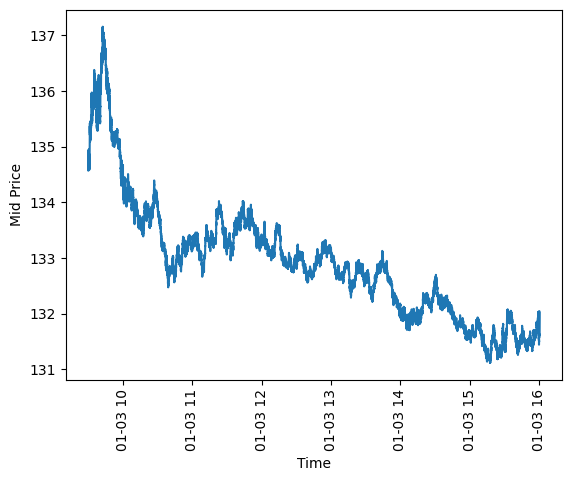

In [6]:
print(df.DateTime.size)
plt.plot(df.DateTime, df.MidPrice)
plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.xticks(rotation=90)
plt.show()

In [7]:
df.head(3)

,DateTime,Event_Type,Order_ID,Size,Price,Direction,Ask_Price_Level_1,Ask_Volume_Level_1,Bid_Price_Level_1,Bid_Volume_Level_1,...,Bid_Volume_Level_8,Ask_Price_Level_9,Ask_Volume_Level_9,Bid_Price_Level_9,Bid_Volume_Level_9,Ask_Price_Level_10,Ask_Volume_Level_10,Bid_Price_Level_10,Bid_Volume_Level_10,MidPrice
0,2019-01-03 09:30:00.690212,1,7611690.0,10,1348100.0,-1,134.80,30,134.5,630,...,203,135.00,3781,133.99,1,135.09,25,133.9,80,134.65
1,2019-01-03 09:30:00.690246,1,7611990.0,100,1347800.0,-1,134.78,100,134.5,630,...,203,134.99,100,133.99,1,135.00,3781,133.9,80,134.64
2,2019-01-03 09:30:00.690267,3,7611690.0,10,1348100.0,-1,134.78,100,134.5,630,...,203,135.00,3781,133.99,1,135.09,25,133.9,80,134.64


In [8]:
average_spread = np.mean(df.Ask_Price_Level_1 - df.Bid_Price_Level_1)
print(f"Average spread for stock {stock}: {round(average_spread, 2)}")

Average spread for stock FB: 0.05


In [9]:
prices_volumes = df.iloc[:, 6:-1]
prices_ask_side = prices_volumes.iloc[:, 0::4]
prices_bid_side = prices_volumes.iloc[:, 2::4]

flatten_ask_diff = np.array(prices_ask_side.diff(axis=1).iloc[:, 1:]).flatten()
flatten_bid_diff = np.array(prices_bid_side.diff(axis=1).iloc[:, 1:]).flatten()

flatten_bid_ask = np.concatenate((flatten_ask_diff, flatten_bid_diff))

empirical_tick_size = np.mean(np.abs(flatten_bid_ask))
print(f"Empirical tick size for stock {stock}: {round(empirical_tick_size, 2)}")

Empirical tick size for stock FB: 0.01


### Analysis of returns

We can define multiple types of returns in LOB. Each of them has a different meaning. Here we will analyse the simplest definition of LOB returns. As a first step we need to group ticks in bins with a fixed time size (e.g. 1s, 10s, 1T, 1H, ...).

In [10]:
bin_size = '10s'
groups_by_secs = df.groupby(pd.Grouper(key='DateTime', freq=bin_size))

In [11]:
group_ticks_len = []
open_mid = []
high_mid = []
low_mid = []
close_mid = []
number_missing_seconds = 0

for k in groups_by_secs:
    if len(k[1] != 0):
        group_ticks_len.append(len(k[1]))
        open_mid.append(list(k[1].MidPrice)[0])
        high_mid.append(max(list(k[1].MidPrice)))
        low_mid.append(min(list(k[1].MidPrice)))
        close_mid.append(list(k[1].MidPrice)[-1])
    else:
        number_missing_seconds += 1

In [12]:
print(f"Average bins length: {round(np.mean(group_ticks_len), 2)} ticks.")
print(f"Std bins' length: {round(np.std(group_ticks_len), 2)} ticks.")
print(f"Number of missing bins (={bin_size}) in one trading day: {number_missing_seconds}")
print(f"Average mid price: {round(np.mean(close_mid), 2)}$")

Average bins length: 334.97 ticks.
Std bins' length: 230.97 ticks.
Number of missing bins (=10s) in one trading day: 0
Average mid price: 132.93$


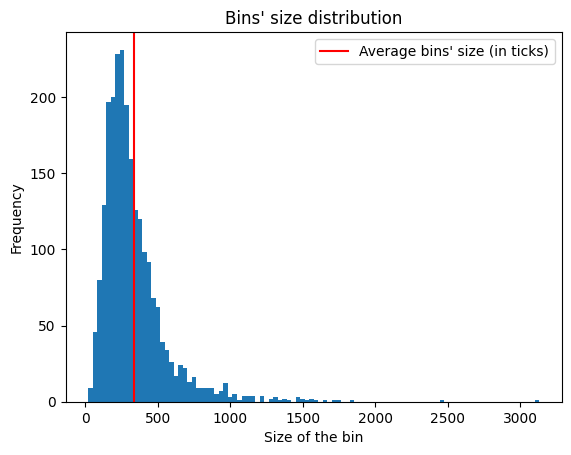

In [13]:
plt.hist(group_ticks_len, bins=100)
plt.axvline(np.mean(group_ticks_len), color='red', label="Average bins' size (in ticks)")
plt.title("Bins' size distribution")
plt.xlabel('Size of the bin')
plt.ylabel('Frequency')
plt.legend()
plt.show()

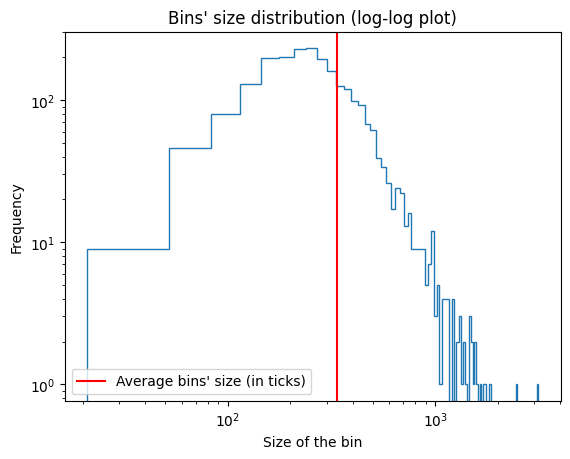

In [14]:
plt.hist(group_ticks_len, bins=100, histtype='step')
plt.axvline(np.mean(group_ticks_len), color='red', label="Average bins' size (in ticks)")
plt.xscale('log')
plt.yscale('log')
plt.title("Bins' size distribution (log-log plot)")
plt.xlabel('Size of the bin')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Let's transform bins into OHLC (open, high, low, close) data.

In [15]:
ohlc = pd.DataFrame({'Open':open_mid, 'High':high_mid, 'Low':low_mid, 'Close':close_mid})

In [16]:
log_rets_definition_1 = (np.log(ohlc.Close) - np.log(ohlc.Close.shift(1)))
log_rets_definition_2 = np.log(ohlc.Close / ohlc.Close.shift(1)).dropna()

In [17]:
log_rets = log_rets_definition_1

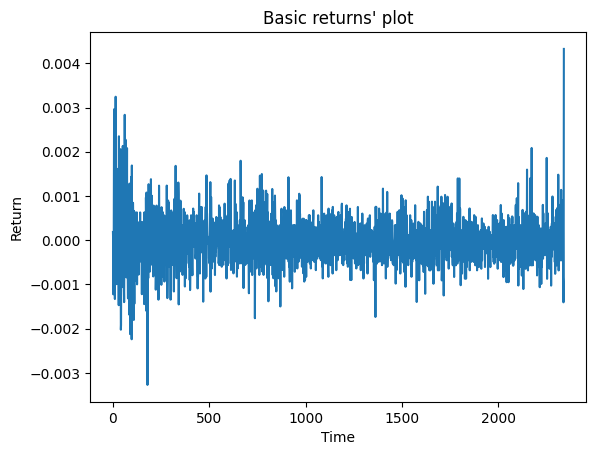

In [18]:
plt.plot(log_rets)
plt.xlabel('Time')
plt.ylabel('Return')
plt.title("Basic returns' plot")
plt.show()

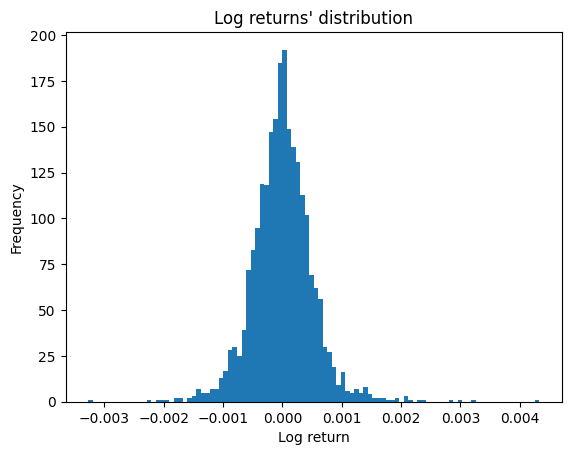

In [19]:
plt.hist(log_rets, bins=100)
plt.xlabel('Log return')
plt.ylabel('Frequency')
plt.title("Log returns' distribution")
plt.show()

Text(0.5, 1.0, "Log returns' distribution (log-log plot)")

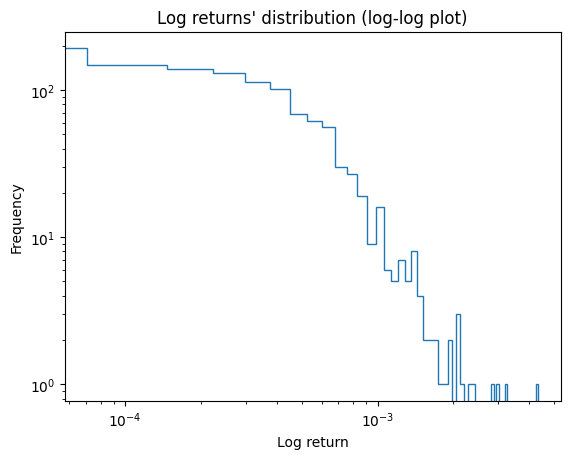

In [20]:
plt.hist(log_rets, bins=100, histtype='step')
plt.xlabel('Log return')
plt.ylabel('Frequency')
plt.xscale('log')
plt.yscale('log')
plt.title("Log returns' distribution (log-log plot)")

Let's try to study normality of returns' distribution based on the empirical kurtosis.

In [21]:
def compute_empirical_kurtosis(arr):
    mean_ = np.mean(arr)
    mu2 = np.mean((arr-mean_)**2)
    mu4 = np.mean((arr - mean_)**4)
    kurtosis = (mu4 / (mu2**2))-3
    return kurtosis

In [22]:
print(f"Empirical kurtosis of {stock} stock's returns is equal to {round(compute_empirical_kurtosis(log_rets), 2)}.")

Empirical kurtosis of FB stock's returns is equal to 5.4.


Let's now generate random normally distributed data and let's see what is its kurtosis.

In [23]:
mu, sigma = 0, 1
random_normal_data = np.random.normal(mu, sigma, 1000000)

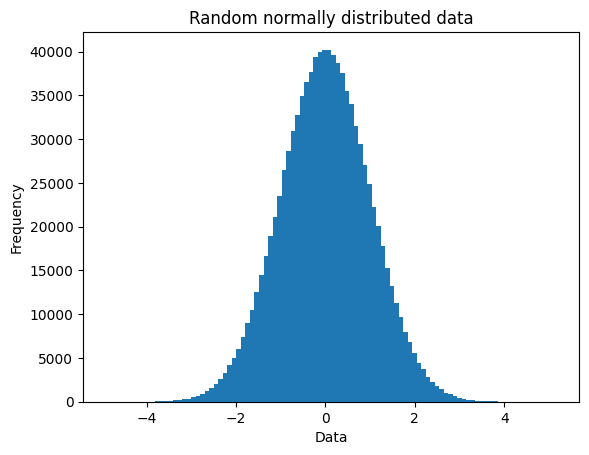

In [24]:
plt.hist(random_normal_data, bins=100)
plt.xlabel('Data')
plt.ylabel('Frequency')
plt.title("Random normally distributed data")
plt.show()

In [25]:
print(f"Empirical kurtosis of normally distributed random data {round(compute_empirical_kurtosis(random_normal_data), 2)}.")

Empirical kurtosis of normally distributed random data 0.01.


In [26]:
def daily_volatility(data):
    return np.std(data)

In [27]:
log_rets = (np.log(ohlc.Close) - np.log(ohlc.Close.shift(1))).dropna()/daily_volatility(ohlc.Close)

In [28]:
N = len(log_rets)
mean = sum(log_rets)/N
std = np.sqrt(sum((log_rets-mean)**2)/N)

In [29]:
'''# Gaussian PDF
x = np.linspace(min(log_rets),max(log_rets),100)
g = sts.norm.pdf(x, mean, std)#np.exp(-(x-mean)**2/(2*std**2))/np.sqrt(2*np.pi*std**2)

# Gaussian vs empirical PDF
plt.hist(log_rets, bins=100, label='Empirical PDF')
plt.plot(x, g, label='Gaussian PDF')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()'''

"# Gaussian PDF\nx = np.linspace(min(log_rets),max(log_rets),100)\ng = sts.norm.pdf(x, mean, std)#np.exp(-(x-mean)**2/(2*std**2))/np.sqrt(2*np.pi*std**2)\n\n# Gaussian vs empirical PDF\nplt.hist(log_rets, bins=100, label='Empirical PDF')\nplt.plot(x, g, label='Gaussian PDF')\nplt.xlabel('Returns')\nplt.ylabel('Frequency')\nplt.legend()"

In [30]:

# def ccdf(data):
#     data = np.sort(data)
#     x, counts = np.unique(data, return_counts=True) #https://numpy.org/doc/stable/reference/generated/numpy.unique.html
#     # the fraction of [observations] that are less than or equal to x
#     events = np.cumsum(counts)
#     n = data.size
#     cdf = events / n
#     empc= 1-cdf
#     return x, empc

def ccdf(data):
     data = np.sort(data)
     x, count = np.unique(data, return_counts = True)
     n = data.size
     events = np.cumsum(count)
     cdf = events / n
     y = 1 - cdf
     return (x, y)

def gaussian_ccdf(data):
    x = np.array(sorted(data))
    N = len(data)
    mean = sum(data)/N
    std = np.sqrt(sum((data-mean)**2)/N)
    c = 0.5*(1 - sp.special.erf((x-mean)/(std*np.sqrt(2))))
    return(x,c)

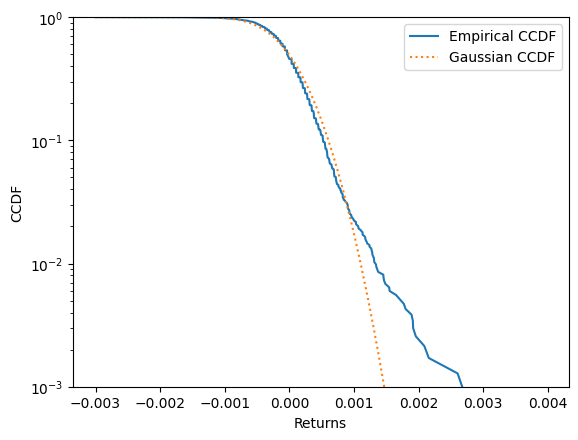

In [49]:
ccdf_rets_x, ccdf_rets_y = ccdf(log_rets)
ccdf_gaussian_x, ccdf_gaussian_y = gaussian_ccdf(log_rets)

plt.semilogy(ccdf_rets_x, ccdf_rets_y, label='Empirical CCDF')
plt.semilogy(ccdf_gaussian_x, ccdf_gaussian_y, label='Gaussian CCDF', ls='dotted')

plt.xlabel('Returns')
plt.ylabel('CCDF')
plt.ylim(10e-4, 1)
plt.legend()
plt.show()

10.0

Let's now study returns' autocorrelation dynamics. We start with a toy example that allows us to better understand how to compute the autocorrelation function.

In [32]:
lags = range(10)

In [33]:
data = [3, 16, 156, 47, 246, 176, 233, 140, 130, 
        101, 166, 201, 200, 116, 118, 247, 
        209, 52, 153, 232, 128, 27, 192, 168, 208, 
        187, 228, 86, 30, 151, 18, 254, 
        76, 112, 67, 244, 179, 150, 89, 49, 83, 147, 90, 
        33, 6, 158, 80, 35, 186, 127]

In [34]:
acorr = len(lags) * [0]

# Mean
mean = sum(data) / len(data) 

# Variance
var = sum([(x - mean)**2 for x in data]) / len(data) 

# Normalised data
ndata = [x - mean for x in data]

In [35]:
print(f"Mean: {mean}")
print(f"Variance: {var}")
print(f"Normalised data: {ndata}")

Mean: 130.6
Variance: 5260.76
Normalised data: [-127.6, -114.6, 25.400000000000006, -83.6, 115.4, 45.400000000000006, 102.4, 9.400000000000006, -0.5999999999999943, -29.599999999999994, 35.400000000000006, 70.4, 69.4, -14.599999999999994, -12.599999999999994, 116.4, 78.4, -78.6, 22.400000000000006, 101.4, -2.5999999999999943, -103.6, 61.400000000000006, 37.400000000000006, 77.4, 56.400000000000006, 97.4, -44.599999999999994, -100.6, 20.400000000000006, -112.6, 123.4, -54.599999999999994, -18.599999999999994, -63.599999999999994, 113.4, 48.400000000000006, 19.400000000000006, -41.599999999999994, -81.6, -47.599999999999994, 16.400000000000006, -40.599999999999994, -97.6, -124.6, 27.400000000000006, -50.599999999999994, -95.6, 55.400000000000006, -3.5999999999999943]


In [36]:
for l in lags:
    c = 1
    
    if (l > 0):
        tmp = []
        for i in range(len(data) - l):
            print(ndata[l:][i])
            print(ndata[:-l][i])
            tmp.append(ndata[l:][i] * ndata[:-l][i])
            print('###')
        
        c = sum(tmp) / (len(data)-l) / var
        
    acorr[l] = c

-114.6
-127.6
###
25.400000000000006
-114.6
###
-83.6
25.400000000000006
###
115.4
-83.6
###
45.400000000000006
115.4
###
102.4
45.400000000000006
###
9.400000000000006
102.4
###
-0.5999999999999943
9.400000000000006
###
-29.599999999999994
-0.5999999999999943
###
35.400000000000006
-29.599999999999994
###
70.4
35.400000000000006
###
69.4
70.4
###
-14.599999999999994
69.4
###
-12.599999999999994
-14.599999999999994
###
116.4
-12.599999999999994
###
78.4
116.4
###
-78.6
78.4
###
22.400000000000006
-78.6
###
101.4
22.400000000000006
###
-2.5999999999999943
101.4
###
-103.6
-2.5999999999999943
###
61.400000000000006
-103.6
###
37.400000000000006
61.400000000000006
###
77.4
37.400000000000006
###
56.400000000000006
77.4
###
97.4
56.400000000000006
###
-44.599999999999994
97.4
###
-100.6
-44.599999999999994
###
20.400000000000006
-100.6
###
-112.6
20.400000000000006
###
123.4
-112.6
###
-54.599999999999994
123.4
###
-18.599999999999994
-54.599999999999994
###
-63.599999999999994
-18.5999999

Let's now come back to our returns.

In [37]:
absolute_log_rets = np.abs(np.array(log_rets))
lags = range(100)

In [38]:
# Pre-allocate autocorrelation table
acorr = len(lags) * [0]

# Mean
mean = sum(absolute_log_rets) / len(absolute_log_rets) 

# Variance
var = sum([(x - mean)**2 for x in absolute_log_rets]) / len(absolute_log_rets) 

# Normalized data
ndata = [x - mean for x in absolute_log_rets]

for l in lags:
    c = 1
    
    if (l > 0):
        tmp = [ndata[l:][i] * ndata[:-l][i] 
               for i in range(len(ndata) - l)]
        c = sum(tmp) / (len(ndata)) / var
        
    acorr[l] = c

Text(0, 0.5, 'Correlation')

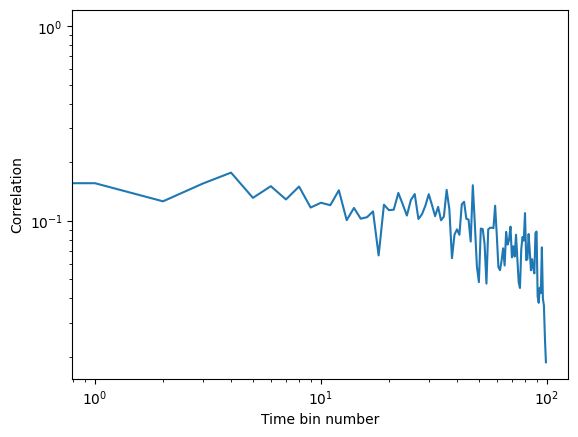

In [39]:
plt.plot(acorr)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time bin number')
plt.ylabel('Correlation')

Let's now compute the same quantities using a library.

In [40]:
acorr = sm.tsa.acf(absolute_log_rets, nlags = len(lags)-1)

Text(0, 0.5, 'Correlation')

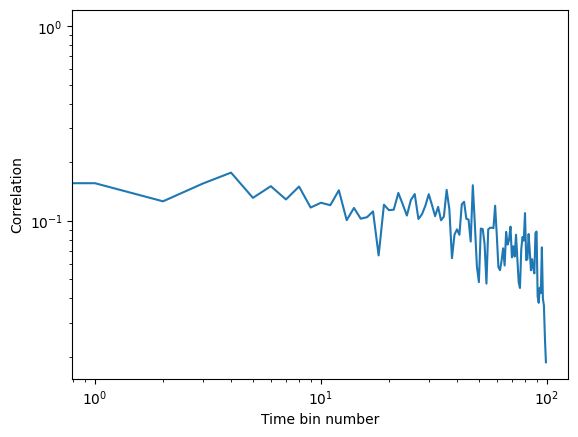

In [41]:
plt.plot(acorr)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time bin number')
plt.ylabel('Correlation')

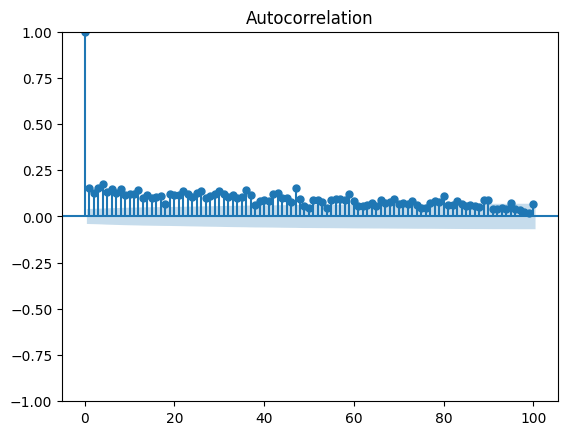

In [42]:
sm.graphics.tsa.plot_acf(absolute_log_rets, lags=100, alpha=0.05)
plt.show()

Let's now compute the variogram.

In [43]:
vdata = np.array(log_rets)

# Variance
var = sum([(x - mean)**2 for x in vdata]) / len(vdata)
# var = np.var(vdata)

In [44]:
vvalues = len(lags) * [0]

 $$\frac{1}{2N\sigma^2} \sum_{i=1}^{N-l} (x_{i+l} - x_i)^2$$

In [45]:
lags = range(100)

for l in lags:
    # c = 1
    c = 0
    
    if (l > 0):
        tmp = []
        for i in range(len(vdata) - l):
            tmp.append((vdata[l:][i] - vdata[:-l][i])**2)
        
        c = sum(tmp) / len(vdata) / (2 * var)
        
    vvalues[l] = c

# def variogram(data, lag):
#     if lag == 0:
#         return 0
#     else:
#         return 0.5 * np.mean((data[lag:] - data[:-lag])**2)

# vvalues2 = [variogram(vdata, l) for l in lags]

In [46]:
print(vvalues[:5])
print(vvalues2[:5])

[0, 0.6393668611386977, 0.657075424243826, 0.6333657439269057, 0.629359775135513]


NameError: name 'vvalues2' is not defined

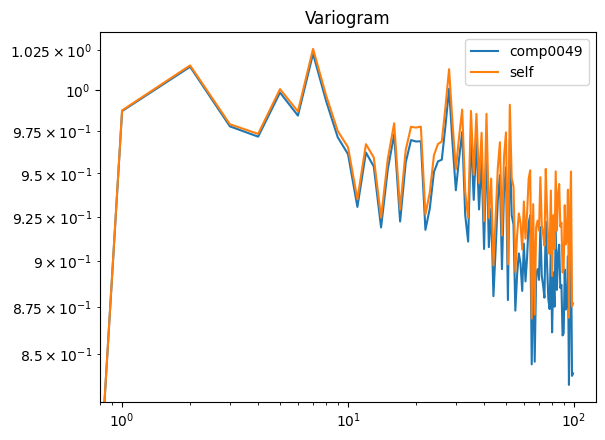

In [ ]:
plt.clf()
plt.plot(lags, vvalues, label = "comp0049")
plt.plot(lags, vvalues2 / var, label = "self")
plt.xscale('log')
plt.yscale('log')
plt.title('Variogram')
plt.legend()
plt.show()

As an exercise try to compute the correlogram of log-returns (not absolute log-returns) and try to sum it to the corresponding variogram.

In [ ]:
'''plt.clf()
plt.plot(acorr[1:])
plt.plot(vvalues[1:])
plt.plot([x + y for x, y in zip(acorr[1:], vvalues[1:])])'''

'plt.clf()\nplt.plot(acorr[1:])\nplt.plot(vvalues[1:])\nplt.plot([x + y for x, y in zip(acorr[1:], vvalues[1:])])'

Let's put all toghether now.

In [ ]:
stocks = ['JNJ', 'GOOG', 'TSLA', 'MSFT']
colors = ['red', 'blue', 'black', 'orange']

In [ ]:
stocks_dict = {}

for s in stocks:
    all_files = glob.glob(f"./Stocks/{s}/cleaned_data/*.*")
    
    df = pd.read_csv(all_files[0])
    df.DateTime = pd.to_datetime(df.DateTime, format='%Y-%m-%d %H:%M:%S:%f')
    df['MidPrice'] = (df.Ask_Price_Level_1 + df.Bid_Price_Level_1)/2
    
    average_spread = np.mean(df.Ask_Price_Level_1 - df.Bid_Price_Level_1)
    print(f"Average spread for stock {s}: {round(average_spread, 2)}")
    
    prices_volumes = df.iloc[:, 6:-1]
    prices_ask_side = prices_volumes.iloc[:, 0::4]
    prices_bid_side = prices_volumes.iloc[:, 2::4]

    flatten_ask_diff = np.array(prices_ask_side.diff(axis=1).iloc[:, 1:]).flatten()
    flatten_bid_diff = np.array(prices_bid_side.diff(axis=1).iloc[:, 1:]).flatten()

    flatten_bid_ask = np.concatenate((flatten_ask_diff, flatten_bid_diff))

    empirical_tick_size = np.mean(np.abs(flatten_bid_ask))
    print(f"Empirical tick size for stock {s}: {round(empirical_tick_size, 2)}")
    
    stocks_dict[s] = df
    print('###')

IndexError: list index out of range

In [ ]:
ohlc_dict = {}

for s in stocks:
    df = stocks_dict[s]
    bin_size = '10s'
    groups_by_secs = df.groupby(pd.Grouper(key='DateTime', freq=bin_size))
    
    group_ticks_len = []
    open_mid = []
    high_mid = []
    low_mid = []
    close_mid = []
    number_missing_seconds = 0

    for k in groups_by_secs:
        if len(k[1] != 0):
            group_ticks_len.append(len(k[1]))
            open_mid.append(list(k[1].MidPrice)[0])
            high_mid.append(max(list(k[1].MidPrice)))
            low_mid.append(min(list(k[1].MidPrice)))
            close_mid.append(list(k[1].MidPrice)[-1])
        else:
            number_missing_seconds += 1
            
    ohlc = pd.DataFrame({'Open':open_mid, 'High':high_mid, 'Low':low_mid, 'Close':close_mid})
    ohlc_dict[s] = ohlc

In [ ]:
rets_dict = {}

for s in stocks:
    ohlc = ohlc_dict[s]
    log_rets = (np.log(ohlc.Close) - np.log(ohlc.Close.shift(1))).dropna()
    rets_dict[s] = log_rets

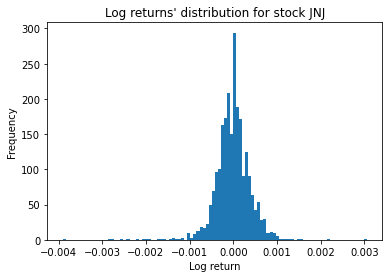

Empirical kurtosis of JNJ stock's returns is equal to 10.59.
##########################################


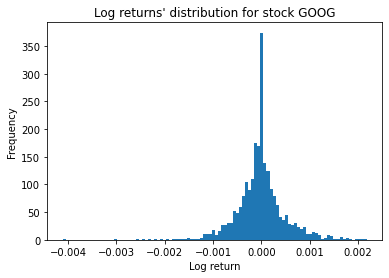

Empirical kurtosis of GOOG stock's returns is equal to 4.79.
##########################################


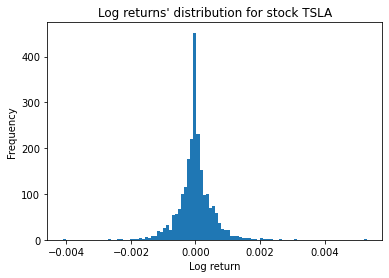

Empirical kurtosis of TSLA stock's returns is equal to 8.77.
##########################################


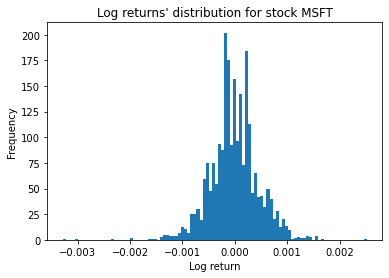

Empirical kurtosis of MSFT stock's returns is equal to 3.06.
##########################################


In [ ]:
for s in stocks:
    plt.clf()
    plt.hist(rets_dict[s], bins=100)
    plt.xlabel('Log return')
    plt.ylabel('Frequency')
    plt.title(f"Log returns' distribution for stock {s}")
    plt.show()
    print(f"Empirical kurtosis of {s} stock's returns is equal to {round(compute_empirical_kurtosis(rets_dict[s]), 2)}.")
    print('##########################################')

<Figure size 640x480 with 0 Axes>

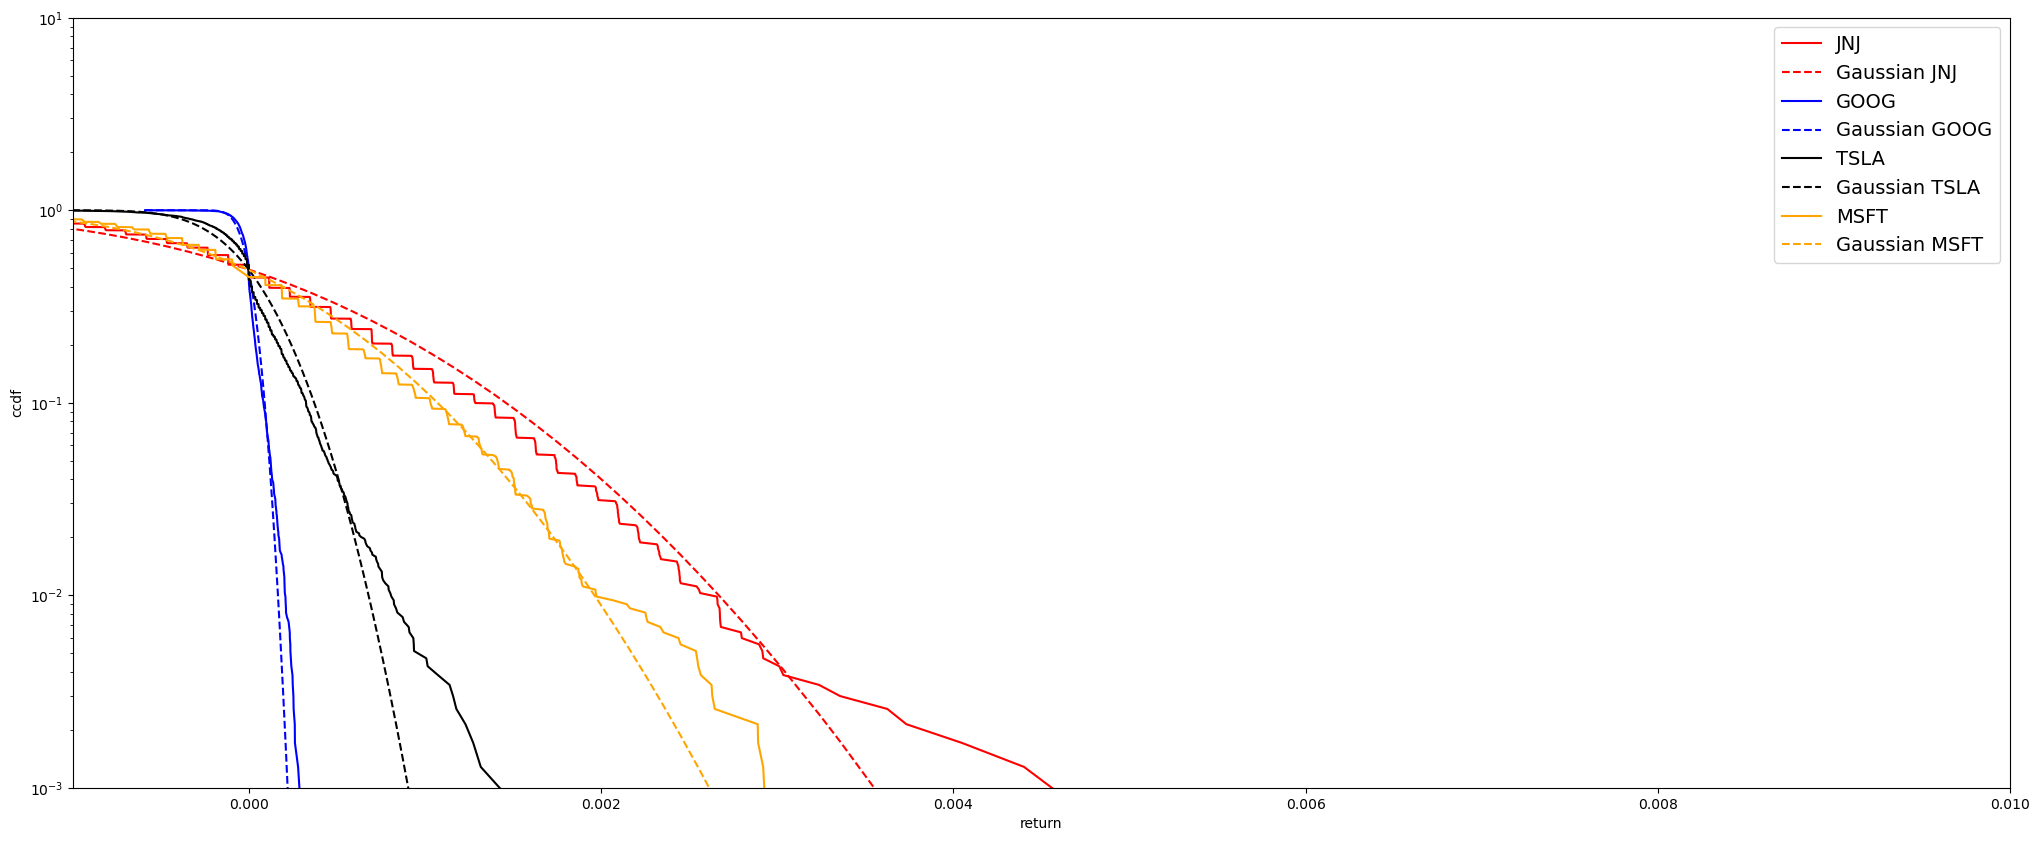

In [ ]:
plt.clf()
plt.figure(figsize=(25,10))
for s, c in zip(stocks, colors):
    ohlc = ohlc_dict[s]
    log_rets = (np.log(ohlc.Close) - np.log(ohlc.Close.shift(1))).dropna()/daily_volatility(ohlc.Close)
    
    ccdf_rets_x, ccdf_rets_y = ccdf(log_rets)
    ccdf_gaussian_x, ccdf_gaussian_y = gaussian_ccdf(log_rets)
    
    plt.semilogy(ccdf_rets_x, ccdf_rets_y, label=s, color=c)
    plt.semilogy(ccdf_gaussian_x, ccdf_gaussian_y, ls='--', label=f"Gaussian {s}", color=c)
    plt.xlabel('return')
    plt.ylabel('ccdf')
    plt.xlim(-10e-4, 10e-3)
    plt.ylim(10e-4, 10e0)

plt.legend(fontsize=14)
plt.show()